# Вариант №10

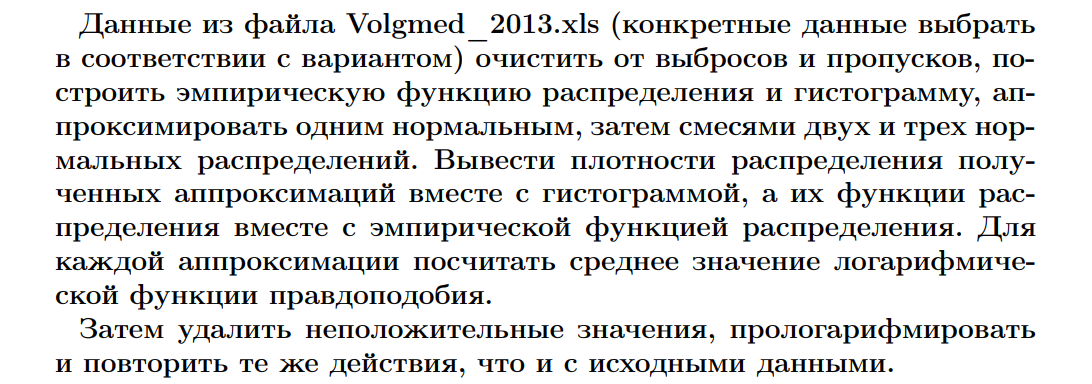
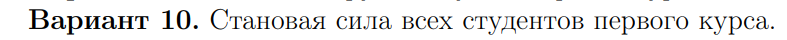

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import statsmodels
from math import sqrt, log, exp, pi
from random import uniform
from sklearn.mixture import GaussianMixture

In [109]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Анализ данных на Python/Volgmed_2013.xlsx', header=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12375 entries, 0 to 12374
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   № п/п                                    193 non-null    float64       
 1   Пол                                      3190 non-null   object        
 2   Год рождения                             3095 non-null   float64       
 3   Факультет                                3510 non-null   object        
 4   Курс                                     3318 non-null   float64       
 5   Группа                                   3310 non-null   float64       
 6   Год поступления                          3400 non-null   object        
 7   Дата обследования                        12009 non-null  datetime64[ns]
 8   Рост, см                                 2543 non-null   object        
 9   Вес, кг                                

In [110]:
# отбираем нужные данные, удаляем пропуски, преобразуем в тип float
data = data[['Курс', 'Становая сила, кг']]
data_course = data[data['Курс'] == 1]
data_course = data_course.dropna(axis=0, how='any')
data_course = data_course[data_course['Становая сила, кг'] != 'осв.']
data_course['Становая сила, кг'] = data_course['Становая сила, кг'].astype('float')
data_course.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 4095
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Курс               1018 non-null   float64
 1   Становая сила, кг  1018 non-null   float64
dtypes: float64(2)
memory usage: 23.9 KB


In [111]:
# избавляемся от выбросов
array=data_course.to_numpy()
q_025 = np.quantile(array[:, 1], 0.25)
q_075 = np.quantile(array[:, 1], 0.75)
iqd = q_075 - q_025
upper_limit = q_075 + 1.5 * iqd
lower_limit = q_025 - 1.5 * iqd

print('Верхняя граница =', upper_limit)
print('Нижняя граница =', lower_limit)

data_course = data_course[(data_course['Становая сила, кг'] < upper_limit) & (data_course['Становая сила, кг'] > lower_limit)]

# сортировка
data_sorted = data_course.sort_values(by='Становая сила, кг')
data_sorted

Верхняя граница = 137.5
Нижняя граница = -2.5


,Курс,"Становая сила, кг"
164,1.0,20.0
3356,1.0,20.0
3881,1.0,20.0
3863,1.0,25.0
3556,1.0,25.0
...,...,...
470,1.0,135.0
875,1.0,135.0
503,1.0,135.0
2763,1.0,135.0


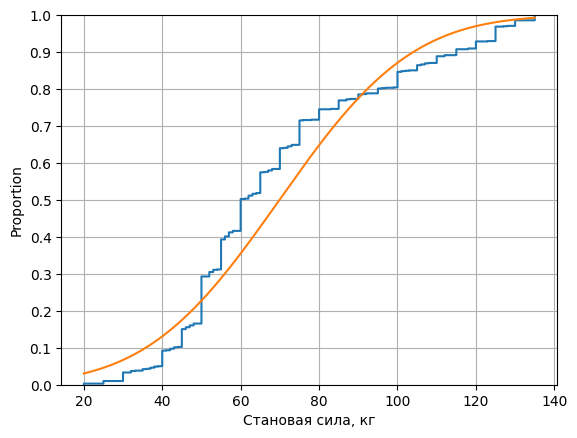

In [112]:
# эмпирическая функция распределения
data_cut = data_sorted['Становая сила, кг']
ax = sns.ecdfplot(data_cut)
ax.axes.set_yticks(np.arange(start=0, stop=1.1, step=0.1))
ax.grid()

X=np.linspace(20, 135, num=2000)
Y=norm.cdf(X, np.mean(data_cut), np.std(data_cut))
plt.plot(X, Y)
plt.show()

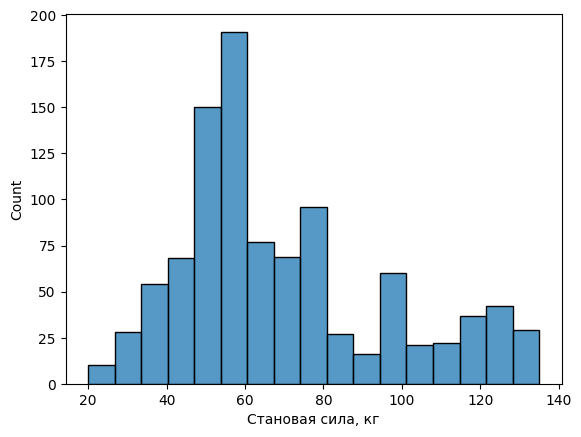

In [113]:
# гистограмма
sns.histplot(data_cut)
plt.show()

In [114]:
# функция для аппроксимаиця смесями нормальных распределений
def gaussian_mixture(data, number):
  x = np.linspace(min(data), max(data), 2000)
  gmm = GaussianMixture(n_components = number, tol=0.000001)
  gmm.fit(np.expand_dims(data, 1))
  Gaussian_nr = 1

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  sns.ecdfplot(data, ax=axes[1])
  axes[1].set_yticks(np.arange(start=0, stop=1.1, step=0.1))
  axes[1].grid()

  for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print("Gaussian {:}: mu = {:.2}, sigma = {:.2}, weight = {:.2}".format(Gaussian_nr, mu, sd, p))
    g_s = stats.norm(mu, sd).pdf(x) * p
    axes[0].plot(x, g_s, label="gaussian sklearn")
    axes[1].plot(x, p*norm.cdf(x, mu, sd))
    Gaussian_nr += 1

  sns.histplot(data, kde=False, stat="density", ax=axes[0])
  gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x])
  axes[0].plot(x, gmm_sum, label="gaussian mixture");
  axes[0].legend()

  print("Среднее значение логарифмической функции правдоподобия =",gmm.score(np.expand_dims(data, 1)))

  plt.show()

Gaussian 1: mu = 7e+01, sigma = 2.7e+01, weight = 1.0
Среднее значение логарифмической функции правдоподобия = -4.700357596080506


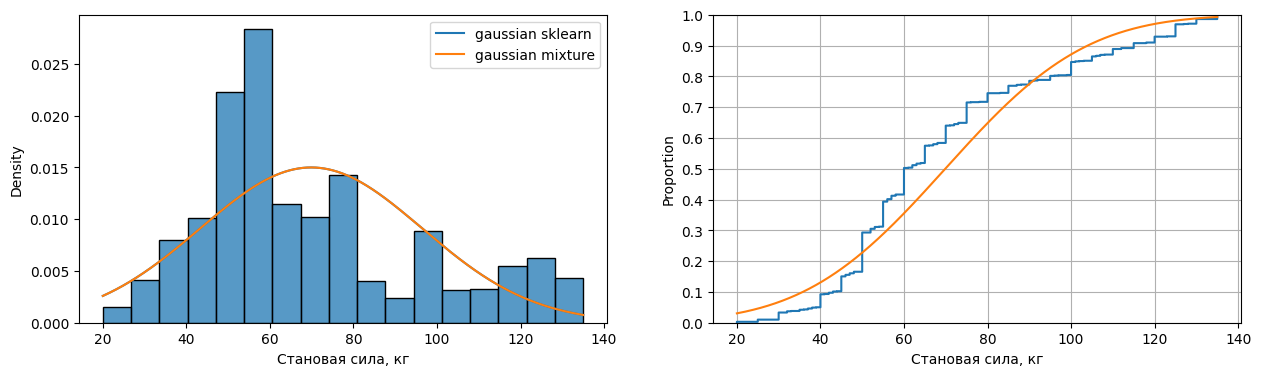

In [115]:
# 1 гауссиан
gaussian_mixture(data_cut, 1)

Gaussian 1: mu = 1.1e+02, sigma = 1.5e+01, weight = 0.23
Gaussian 2: mu = 5.7e+01, sigma = 1.4e+01, weight = 0.77
Среднее значение логарифмической функции правдоподобия = -4.5330762994284965


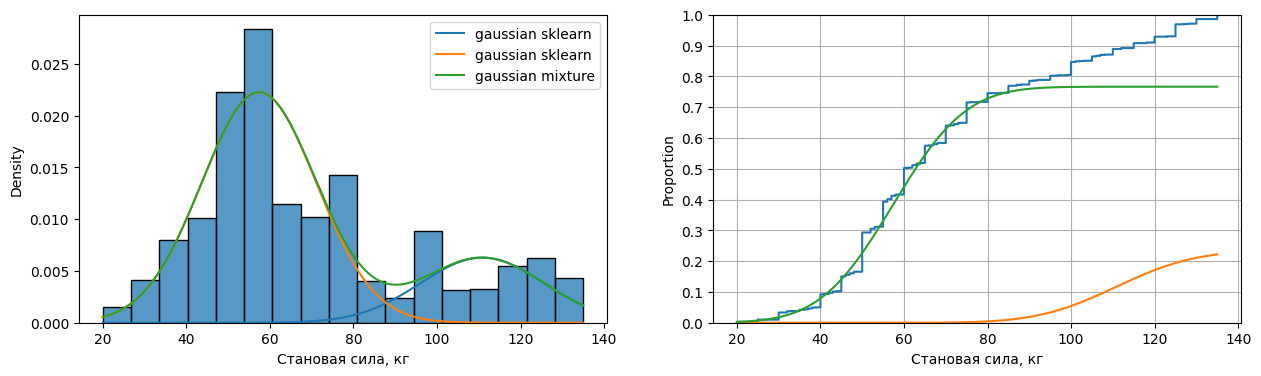

In [116]:
# 2 гауссиана
gaussian_mixture(data_cut, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Gaussian 1: mu = 1e+02, sigma = 1.4e+01, weight = 0.18
Gaussian 2: mu = 5.7e+01, sigma = 1.3e+01, weight = 0.74
Gaussian 3: mu = 1.3e+02, sigma = 5.2, weight = 0.074
Среднее значение логарифмической функции правдоподобия = -4.515331979421659


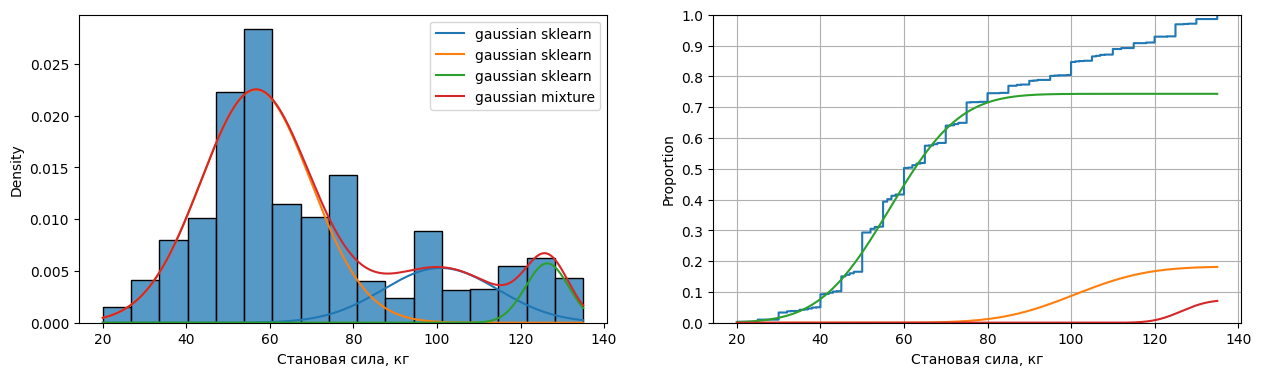

In [117]:
# 3 гауссиана
gaussian_mixture(data_cut, 3)

In [118]:
# логарифмируем данные, избавляемся от отрицательных и выбросов
data_log = np.log(data_cut)
data_log = data_log[data_log > 0]

array=data_log.to_numpy()
q_025 = np.quantile(array, 0.25)
q_075 = np.quantile(array, 0.75)
iqd = q_075 - q_025
upper_limit = q_075 + 1.5 * iqd
lower_limit = q_025 - 1.5 * iqd

print('Верхняя граница =', upper_limit)
print('Нижняя граница =', lower_limit)
data_log = data_log[(data_log < upper_limit) & (data_log > lower_limit)]
data_log = data_log.sort_values()
data_log

Верхняя граница = 5.238593633083573
Нижняя граница = 3.11608062883489


,"Становая сила, кг"
3863,3.218876
3556,3.218876
3929,3.218876
3302,3.218876
2393,3.218876
...,...
935,4.905275
959,4.905275
4023,4.905275
967,4.905275


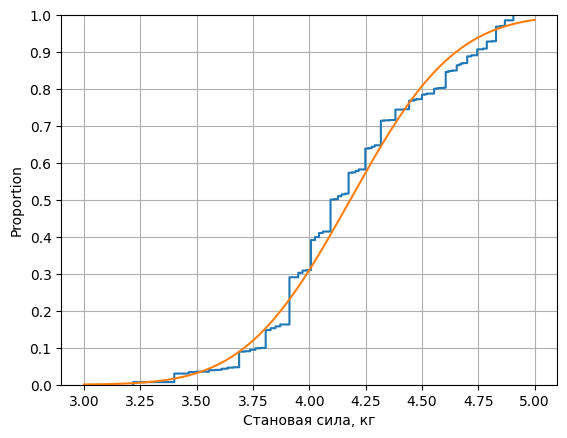

In [119]:
# эмпирическая функция распределения
ax = sns.ecdfplot(data_log)
ax.axes.set_yticks(np.arange(start=0, stop=1.1, step=0.1))
ax.grid()

X=np.linspace(3, 5, num=2000)
Y=norm.cdf(X, np.mean(data_log), np.std(data_log))
plt.plot(X, Y)
plt.show()

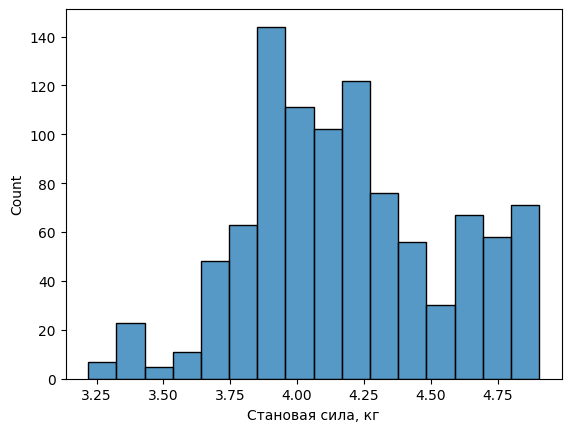

In [120]:
# гистограмма
sns.histplot(data_log)
plt.show()

Gaussian 1: mu = 4.2, sigma = 0.37, weight = 1.0
Среднее значение логарифмической функции правдоподобия = -0.41393277453756416


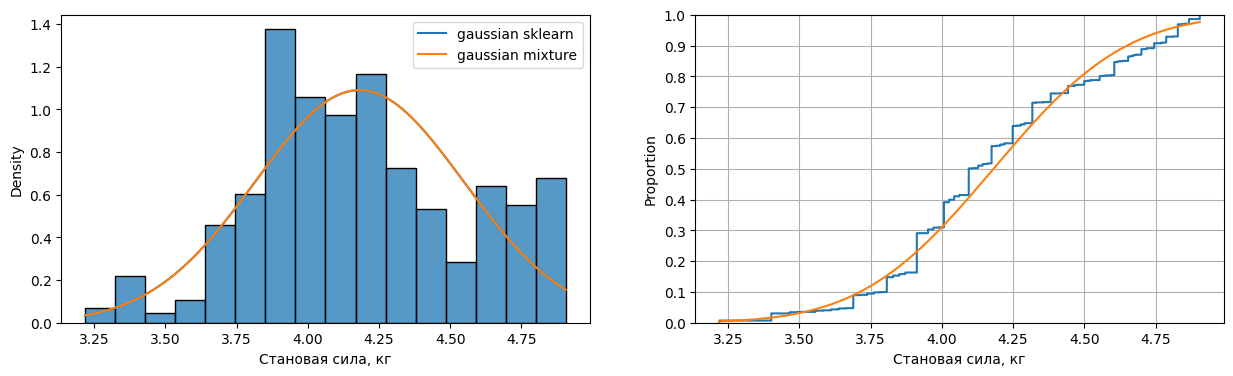

In [121]:
# 1 гауссиан
gaussian_mixture(data_log, 1)

Gaussian 1: mu = 4.7, sigma = 0.1, weight = 0.17
Gaussian 2: mu = 4.1, sigma = 0.28, weight = 0.83
Среднее значение логарифмической функции правдоподобия = -0.3468871581380235


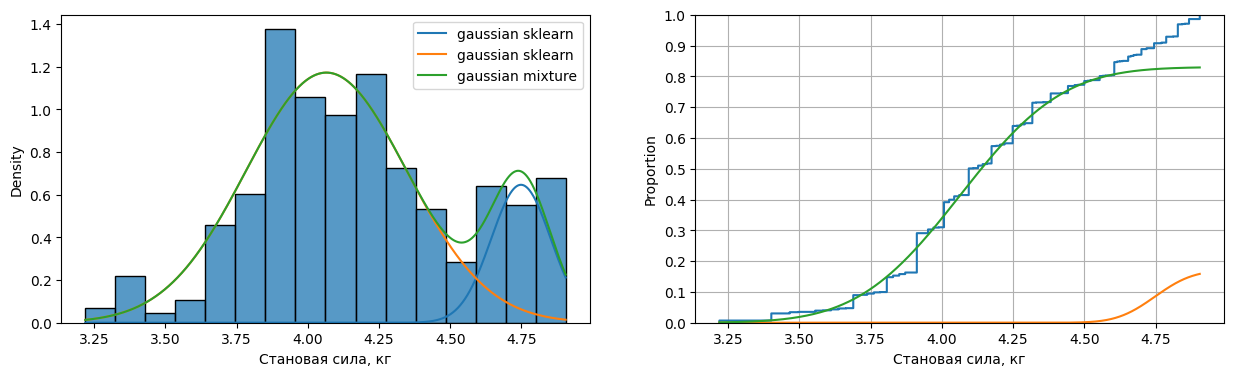

In [122]:
# 2 гауссиана
gaussian_mixture(data_log, 2)

Gaussian 1: mu = 4.1, sigma = 0.23, weight = 0.77
Gaussian 2: mu = 4.7, sigma = 0.11, weight = 0.2
Gaussian 3: mu = 3.4, sigma = 0.087, weight = 0.03
Среднее значение логарифмической функции правдоподобия = -0.32983865763471637


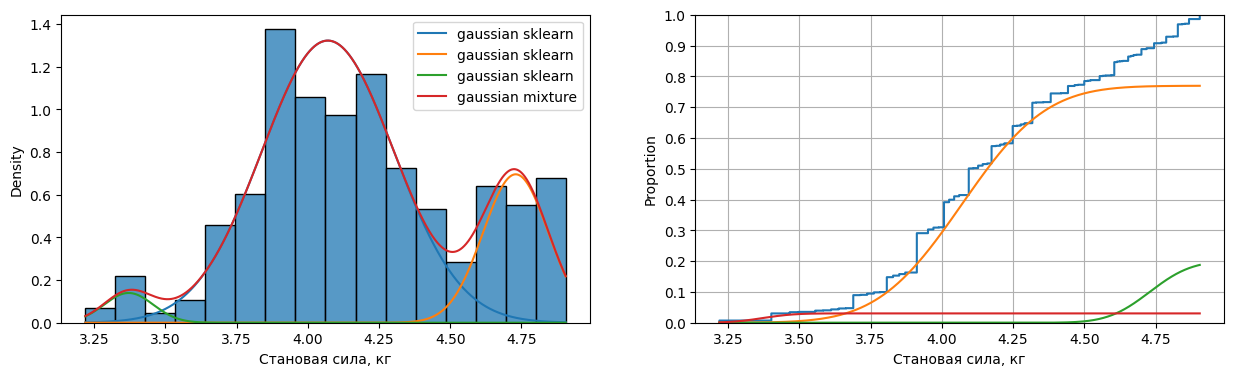

In [123]:
# 3 гауссиана
gaussian_mixture(data_log, 3)